## AUDIO CLASSIFICATION USING CNN

### DATESET USED :  A SUBSET OF ESC-50 

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.3.0


### DATA PREPROCESSING

In [8]:
df = pd.read_csv(r"C:\Users\user\Downloads\ESC-50-master\ESC-50-master\meta\esc50.csv")
df.drop(columns=["fold", "target", "esc10", "src_file", "take"],inplace=True)

df["label"]=df.category

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['category']=encoder.fit_transform(df['category'])
df.head()

,filename,category,label
0,1-100032-A-0.wav,18,dog
1,1-100038-A-14.wav,7,chirping_birds
2,1-100210-A-36.wav,46,vacuum_cleaner
3,1-100210-B-36.wav,46,vacuum_cleaner
4,1-101296-A-19.wav,43,thunderstorm


In [9]:
df=df[df['category']<=4]
df.head()

,filename,category,label
7,1-101404-A-34.wav,3,can_opening
25,1-11687-A-47.wav,0,airplane
51,1-17092-A-27.wav,2,brushing_teeth
52,1-17092-B-27.wav,2,brushing_teeth
53,1-17124-A-43.wav,4,car_horn


In [5]:
df.shape

(200, 3)

In [6]:
df["filename"].iloc[0]

'1-101404-A-34.wav'

<AxesSubplot:xlabel='label'>

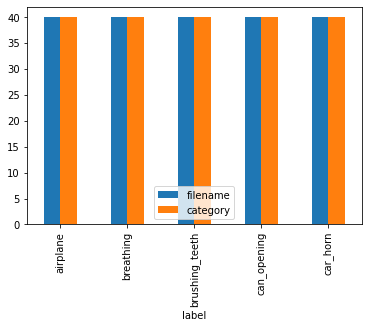

In [10]:
count_category = df.groupby('label').count()
count_category.plot(kind="bar")

#5 CLASSES WITH 40 SAMPLES EACH

In [3]:
path=r"C:\Users\user\Downloads\ESC-50-master\ESC-50-master\audio" 
data=os.listdir(path)
data[:2]

['1-100032-A-0.wav', '1-100038-A-14.wav']

In [7]:
df.dropna(inplace=True)

In [8]:
new_path=os.path.join(path, df['filename'].iloc[0])
from IPython.display import Audio
Audio(new_path)

### FEATURE EXTRACTION USING PYDUB

In [29]:
from pydub import AudioSegment

wav_file = AudioSegment.from_file(file=new_path, format="wav") 

print(f"Data type: {type(wav_file)}") 
print(f"Frame rate: {wav_file.frame_rate/1000} kHz")
print(f"Channels: {wav_file.channels}") 
print(f"Number of bytes per sample: {wav_file.sample_width*8} bit") 
print(f"Maximum amplitude: {wav_file.max}")
print(f"Length: {len(wav_file) / 1000.0} s")
print(f"Loudness dBFS: {wav_file.dBFS:.2f} dB")
print(f"Loudness max_dBFS: {wav_file.max_dBFS:.2f} dB")
print(f"Loudness RMS{wav_file.rms}")

Data type: <class 'pydub.audio_segment.AudioSegment'>
Frame rate: 44.1 kHz
Channels: 1
Number of bytes per sample: 16 bit
Maximum amplitude: 32730
Length: 5.0 s
Loudness dBFS: -27.64 dB
Loudness max_dBFS: -0.01 dB
Loudness RMS1360


### VISUALISATION OF THE AUDIO DATA USING LIBROSA

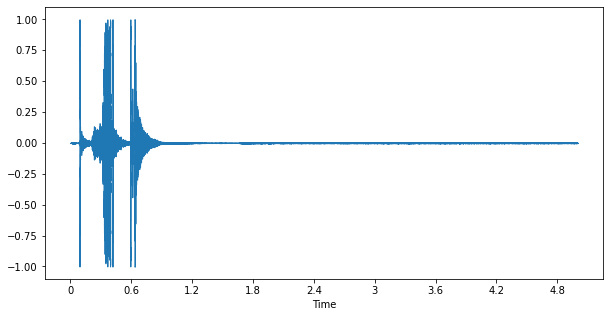

In [9]:
import librosa
import librosa.display

y, sr = librosa.load(new_path, sr=None)

#Plot the amplitude envelope of a waveform.
plt.figure(figsize=(10, 5))
librosa.display.waveshow(y, sr=sr);

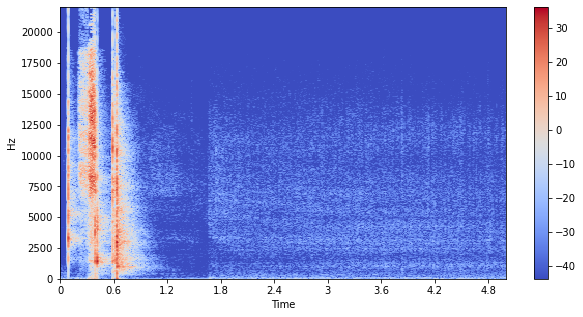

In [15]:
#linear spectogram
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

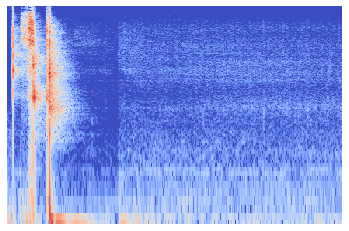

In [16]:
 #logarithmic/normalized spectogram
fig = plt.figure()
plt.axis('off')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')

###  CREATING THE CORRESPONDING IMAGE DATASET

In [28]:

for i in range(0,200):
    filename=df['filename'].iloc[i]
    category=df['category'].iloc[i]
    p=os.path.join(path, df['filename'].iloc[i])
    y, sr = librosa.load(p, sr=None)
    
    #linear spectogram
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig = plt.figure()
    
    #logarithmic/normalized spectogram
    plt.axis('off')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.close()
    

    filen = filename.replace("wav","png")
    fig.savefig('D:\imagetest/{}/{}'.format(str(category), filen))  

### SPLITTING THE DATA

In [68]:
import splitfolders
input_folder=r"D:\imagetest"
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8,.2), group_prefix=None)

Copying files: 200 files [00:00, 741.38 files/s]


In [1]:
train_loc='output/train'
val_loc='output/val'

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# create a new generator
imagegen = ImageDataGenerator()
# load train data
train = imagegen.flow_from_directory(train_loc, class_mode="categorical", shuffle=False, batch_size=32, target_size=(224, 224))
# load val data
val = imagegen.flow_from_directory(val_loc, class_mode="categorical", shuffle=False, batch_size=32, target_size=(224, 224))


Found 160 images belonging to 5 classes.
Found 40 images belonging to 5 classes.


### MODEL 1

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

model1 = Sequential()

#1st Convulation block
model1.add(Conv2D(32, kernel_size=(3, 3),strides=(1,1),padding='same',activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

#2nd Convulation block
model1.add(Conv2D(64, kernel_size=(3, 3),strides=(1,1),padding='same',activation='relu')
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

model1.add(Flatten())

#ANN block
model1.add(Dense(128, activation='relu'))
model1.add(Dense(200, activation='relu'))
#ouput layer
model1.add(Dense(5, activation='softmax'))

# compilation of model
model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# fiiting of data
hist=model1.fit(train, epochs=20, validation_data=val)

Epoch 1/20
5/5 [==============================] - 13s 3s/step - loss: 30.0455 - accuracy: 0.0063 - val_loss: 45.2460 - val_accuracy: 0.2750
Epoch 2/20
5/5 [==============================] - 13s 3s/step - loss: 11.4613 - accuracy: 0.2000 - val_loss: 60.1940 - val_accuracy: 0.2750
Epoch 3/20
5/5 [==============================] - 13s 3s/step - loss: 3.8696 - accuracy: 0.6438 - val_loss: 51.6409 - val_accuracy: 0.3250
Epoch 4/20
5/5 [==============================] - 14s 3s/step - loss: 2.7401 - accuracy: 0.8188 - val_loss: 45.4107 - val_accuracy: 0.3750
Epoch 5/20
5/5 [==============================] - 13s 3s/step - loss: 0.8475 - accuracy: 0.7937 - val_loss: 47.9839 - val_accuracy: 0.3750
Epoch 6/20
5/5 [==============================] - 13s 3s/step - loss: 0.6469 - accuracy: 0.8813 - val_loss: 48.6987 - val_accuracy: 0.3750
Epoch 7/20
5/5 [==============================] - 13s 3s/step - loss: 0.3128 - accuracy: 0.8813 - val_loss: 42.5253 - val_accuracy: 0.3750
Epoch 8/20
5/5 [=========

### MODEL EVALUATION

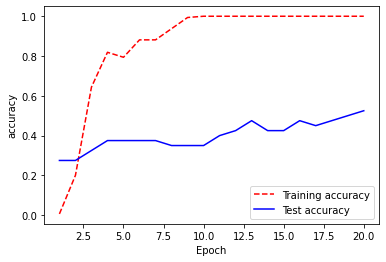

In [6]:
# Get training and test loss histories
training_accuracy = hist.history['accuracy']
test_accuracy = hist.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

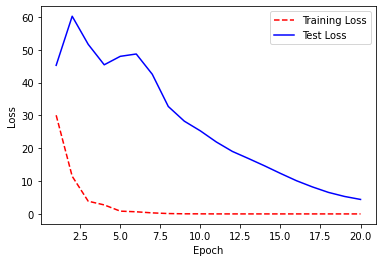

In [7]:
# Get training and test loss histories
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### MODEL 2- (TRANSFER LEARNING USING VGG16)

In [76]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

58892288/58889256 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [77]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(train)
vgg_features_val = pretrained_model.predict(val)

In [78]:
train_target = to_categorical(train.labels)
val_target = to_categorical(val.labels)

In [81]:
model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,512)))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(5, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
history=model2.fit(vgg_features_train, train_target, epochs=25, batch_size=32, validation_data=(vgg_features_val, val_target))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               2508900   
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 505       
Total params: 2,509,805
Trainable params: 2,509,605
Non-trainable params: 200
_________________________________________________________________
Epoch 1/25
5/5 [==============================] - 0s 44ms/step - loss: 1.3997 - accuracy: 0.4250 - val_loss:

### MODEL 2  EVALUATION

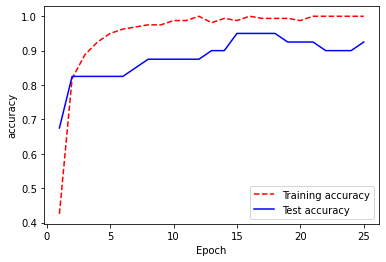

In [83]:
# Get training and test loss histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

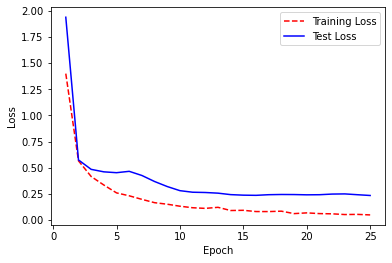

In [84]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()